In [63]:
# Load dataset
import pandas as pd
ratings = pd.read_csv("movielens-100k-dataset/ml-100k/u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])
movies = pd.read_csv("movielens-100k-dataset/ml-100k/u.item", sep="|", encoding="latin-1", header=None)
movies = movies[[0,1]].rename(columns={0: "movie_id", 1: "title"})

# Merge ratings with movie titles into one single dataframe
df = ratings.merge(movies, on="movie_id")
df.head()

,user_id,movie_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [78]:
# Split the data into train-test sets
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Creating user-item matrices where users = rows, movies = columns and the movies which is seen by the user but not rated yet by the user will be filled with 0
train_matrix = train.pivot_table(index="user_id", columns="title", values="rating").fillna(0)
test_matrix = test.pivot_table(index="user_id", columns="title", values="rating").fillna(0)

# Finding the similarity between users rating patterns -> User-based Colaborative Filter
from sklearn.metrics.pairwise import cosine_similarity
user_similarity = cosine_similarity(train_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=train_matrix.index, columns=train_matrix.index)

# A function to recomend movies to the user
def recommend_user_based(user_id, k=5):
    similarity_scores = user_similarity_df[user_id]
    weighted_scores = similarity_scores.dot(train_matrix)/similarity_scores.sum()
    seen = set(train_matrix.loc[user_id][train_matrix.loc[user_id] > 0].index)
    recs = weighted_scores.drop(seen).sort_values(ascending=False).head(k)
    return list(recs.index)

# Evaluate performance using precision at k=5
def precision_at_k(recommend_func, user_id, k=5, threshold=4):
    if user_id not in test_matrix.index:
        return None
    
    recs = recommend_func(user_id, k)
    user_test_ratings = test_matrix.loc[user_id]
    relevant = set(user_test_ratings[user_test_ratings >= threshold].index)
    hits = len(set(recs) & relevant)
    return hits / k

for user_id in user_ids:
    print(f"\nRecommendations for user {user_id}: ", recommend_user_based(user_id, 5))
    precision = precision_at_k(recommend_item_based_for_user, user_id, 5, 4)
    if precision is not None:
        print(f"User {user_id}: {precision:.3f} ({precision*100:.1f}%)")


Recommendations for user 1:  ['Fargo (1996)', 'Return of the Jedi (1983)', 'Toy Story (1995)', 'Back to the Future (1985)', "Schindler's List (1993)"]
User 1: 0.200 (20.0%)

Recommendations for user 2:  ['Return of the Jedi (1983)', 'Twelve Monkeys (1995)', 'Independence Day (ID4) (1996)', 'L.A. Confidential (1997)', 'Silence of the Lambs, The (1991)']
User 2: 0.000 (0.0%)

Recommendations for user 3:  ['English Patient, The (1996)', 'Titanic (1997)', 'Star Wars (1977)', 'Full Monty, The (1997)', 'Liar Liar (1997)']
User 3: 0.000 (0.0%)

Recommendations for user 4:  ['Star Wars (1977)', 'English Patient, The (1996)', 'Titanic (1997)', 'Fargo (1996)', 'L.A. Confidential (1997)']
User 4: 0.000 (0.0%)

Recommendations for user 5:  ['Raiders of the Lost Ark (1981)', 'Pulp Fiction (1994)', 'Godfather, The (1972)', 'Back to the Future (1985)', 'Twelve Monkeys (1995)']
User 5: 0.200 (20.0%)


In [74]:
# Finding the similarity between movies rating patterns -> Item-based Collabrative Filter
item_similarity = cosine_similarity(train_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=train_matrix.columns, columns=train_matrix.columns)

def recommend_item_based(movie_title, k=5):
    similarity_scores = item_similarity_df[movie_title]
    similar_movies = similarity_scores.sort_values(ascending=False).iloc[1:k+1].index.tolist()
    return similar_movies

def recommend_item_based_for_user(user_id, k=5):
    user_ratings = train_matrix.loc[user_id]
    favorite_movies = user_ratings[user_ratings > 3].index.tolist()
    
    if not favorite_movies:
        return []
        
    recommendations = []
    for movie in favorite_movies[:3]:
        similar_movies = recommend_item_based(movie, k=3)
        recommendations.extend(similar_movies)
        
    seen_movies = set(train_matrix.loc[user_id][train_matrix.loc[user_id] > 0].index)
    recommendations = list(set(recommendations) - seen_movies)
    
    return recommendations[:k]
    
print("Movies Similar to Titanic (1997): ", recommend_item_based("Titanic (1997)", 5))
print("\nMovies Similar to Lone Star (1996): ", recommend_item_based("Lone Star (1996)", 5))

for user_id in user_ids:
    precision = precision_at_k(recommend_item_based_for_user, user_id, 5, )
    if precision is not None:
        print(f"User {user_id}: {precision:.3f} ({precision*100:.1f}%)")

Movies Similar to Titanic (1997):  ['Good Will Hunting (1997)', 'Apt Pupil (1998)', 'Tomorrow Never Dies (1997)', 'Contact (1997)', 'Air Force One (1997)']

Movies Similar to Lone Star (1996):  ['Big Night (1996)', 'Fargo (1996)', 'Mighty Aphrodite (1995)', 'Bound (1996)', 'Dead Man Walking (1995)']
User 1: 0.200 (20.0%)
User 2: 0.000 (0.0%)
User 3: 0.200 (20.0%)
User 4: 0.000 (0.0%)
User 5: 0.200 (20.0%)


In [83]:
# Applying Truncated SVD (matrix factorization) to reduce the dimensionality
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=20, random_state=42)
matrix_svd = svd.fit_transform(train_matrix)

# Reconstructing the approximate ratings of user-item matrix
import numpy as np
approximate_ratings = np.dot(matrix_svd, svd.components_)
approximate_ratings_df = pd.DataFrame(approximate_ratings, index=train_matrix.index, columns=train_matrix.columns)

def recommend_svd(user_id, k=5):
    scores = approximate_ratings_df.loc[user_id]
    seen = train_matrix.loc[user_id][train_matrix.loc[user_id] > 0].index
    recs = scores.drop(seen).sort_values(ascending=False).head(k)
    return list(recs.index)

print(f"\n Recommendation for user {user_id}: ", recommend_svd(user_id,5))

print(f"\nPrecision@5 for user {user_id} using Matrix Factorization (SVD):", precision_at_k(recommend_svd, 3, 5, 2))


 Recommendation for user 5:  ['Groundhog Day (1993)', 'Twelve Monkeys (1995)', 'Raising Arizona (1987)', 'Brazil (1985)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)']

Precision@5 for user 5 using Matrix Factorization (SVD): 0.2


Average Precision@5 (User-based CF): 0.24063829787234045
Average Precision@5 (Item-based CF): 0.10319148936170212
Average Precision@5 (SVD): 0.303404255319149


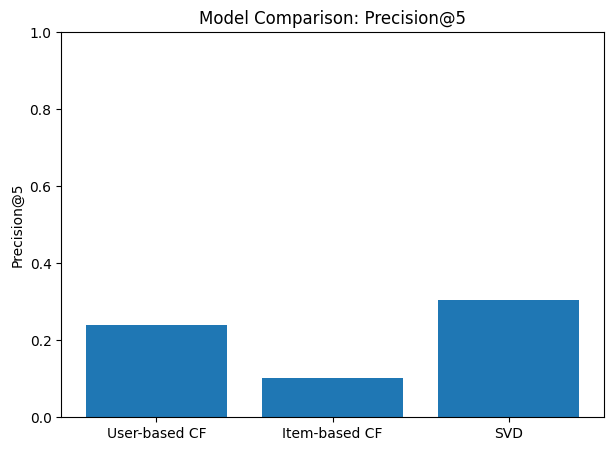

In [101]:
def evaluate_system(recommend_func, k=5):
    precisions = []
    for user in train_matrix.index:
        p = precision_at_k(recommend_func, user, k)
        if p is not None:
            precisions.append(p)
    return np.mean(precisions)

# Compare Models
print("Average Precision@5 (User-based CF):", evaluate_system(recommend_user_based, k=5))
print("Average Precision@5 (Item-based CF):", evaluate_system(recommend_item_based_for_user, k=5))
print("Average Precision@5 (SVD):", evaluate_system(recommend_svd, k=5))

precision_scores = {
    "User-based CF": evaluate_system(recommend_user_based, k=5),
    "Item-based CF": evaluate_system(recommend_item_based_for_user, k=5),
    "SVD": evaluate_system(recommend_svd, k=5)
}

plt.figure(figsize=(7,5))
plt.bar(precision_scores.keys(), precision_scores.values())
plt.ylabel("Precision@5")
plt.title("Model Comparison: Precision@5")
plt.ylim(0, 1)
plt.show()

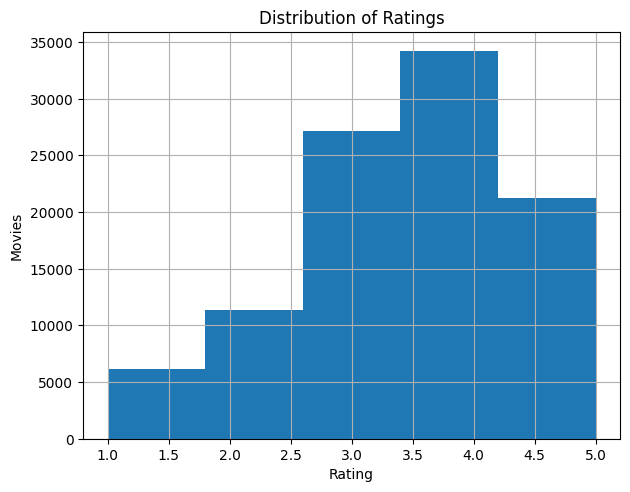

In [94]:
# Ratings Distribution
import matplotlib.pyplot as plt
df['rating'].hist(bins=5)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.title("Distribution of Ratings")
plt.show()

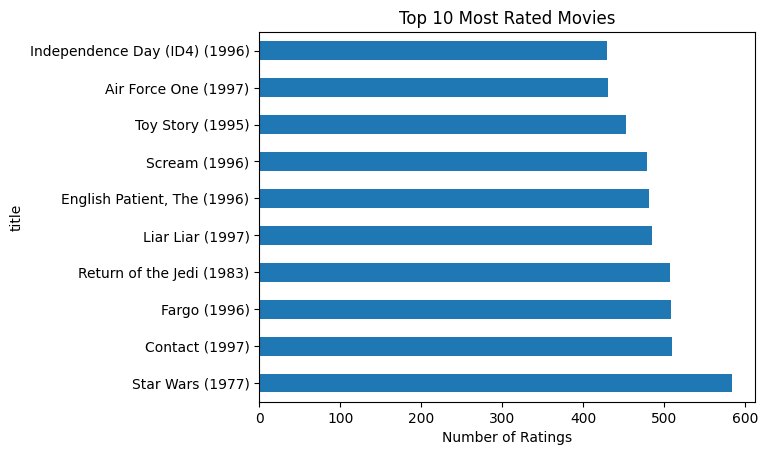

In [96]:
# Top 10 Most Rated Movies
top_movies = df['title'].value_counts().head(10)
top_movies.plot(kind='barh')
plt.xlabel("Number of Ratings")
plt.title("Top 10 Most Rated Movies")
plt.show()

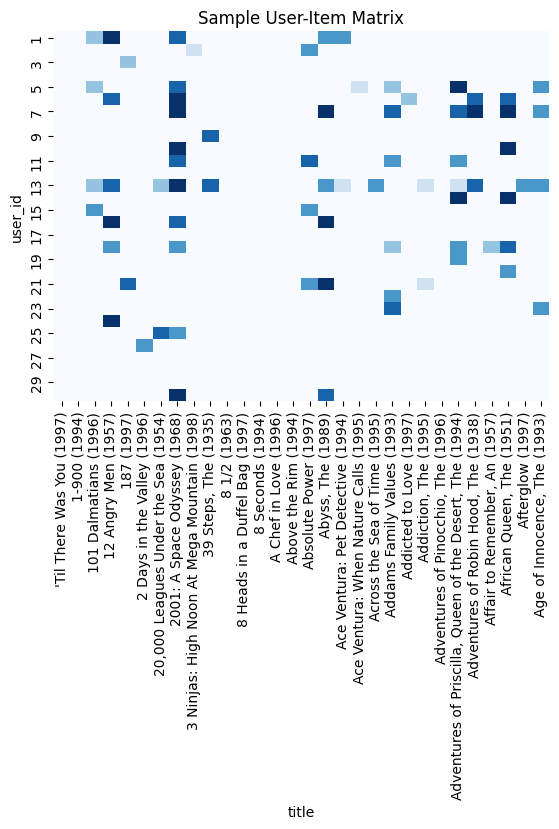

In [106]:
import seaborn as sns

sample_matrix = train_matrix[:30].iloc[:30, :30]
sns.heatmap(sample_matrix.fillna(0), cmap="Blues", cbar=False)
plt.title("Sample User-Item Matrix")
plt.show()